In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

In [3]:
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

In [4]:
from KuhnPoker import KuhnPokerModel, KuhnPokerInfoSet, ActionNode, PASS, ADD_CHIP, Card, TensorModel, SamplingNode
from ISMCTS import Tree, Constants
from AlphaZero import NNModel, SelfPlayDataV, SelfPlayDataP

import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch

In [5]:
start_ix = 0
num_model = 1024

In [6]:
vmodel = []
pmodel = []

for i in range(start_ix, start_ix + num_model):
    vmodel.append(torch.load(f'model_0.001eps/vmodel-{i}.pt'))
    pmodel.append(torch.load(f'model_0.001eps/pmodel-{i}.pt'))

In [7]:
p_info_set = KuhnPokerInfoSet([0], [None, Card.JACK])
q_info_set = KuhnPokerInfoSet([0, 1], [Card.QUEEN, None])
j01_info_set = KuhnPokerInfoSet([0, 1], [None, Card.JACK])
kj01_info_set = KuhnPokerInfoSet([0, 1], [Card.KING, Card.JACK])
qj01_info_set = KuhnPokerInfoSet([0, 1], [Card.QUEEN, Card.JACK])

In [8]:
ps = []
qs = []
vs = []
vs1 = []
vs2 = []
for i in range(num_model):
    p = TensorModel(vmodel[i], pmodel[i]).eval_P(ActionNode(p_info_set))[1]
    q = TensorModel(vmodel[i], pmodel[i]).eval_P(ActionNode(q_info_set))[1]
    
    v, _ = TensorModel(vmodel[i], pmodel[i]).eval_V(SamplingNode(j01_info_set))
    
    kj_node = ActionNode(kj01_info_set)
    kj_node.spawned_tree = 1
    v1, _ = TensorModel(vmodel[i], pmodel[i]).eval_V(kj_node)
    
    qj_node = ActionNode(qj01_info_set)
    qj_node.spawned_tree = 1
    v2, _ = TensorModel(vmodel[i], pmodel[i]).eval_V(qj_node)
    ps.append(p)
    qs.append(q)
    vs.append(v)
    vs1.append(v1)
    vs2.append(v2)
df_model = pd.DataFrame({'p': ps, 'q': qs, 'v_?J[01]': vs, 'v_KJ[01]': vs1, 'v_QJ[01]': vs2})

In [9]:
df_model['err_?J[01]'] = np.abs(df_model['v_?J[01]'] - (-1))
df_model['err_KJ[01]'] = np.abs(df_model['v_KJ[01]'] - (-2))
df_model['err_QJ[01]'] = np.abs(df_model['v_QJ[01]'] - (0))

In [10]:
df_model

,p,q,v_?J[01],v_KJ[01],v_QJ[01],err_?J[01],err_KJ[01],err_QJ[01]
0,0.849398,0.964209,0.862307,2.053578,1.570489,1.862308,4.053577,1.570489
1,0.841789,0.963423,0.288189,0.117903,0.349753,1.288189,2.117903,0.349753
2,0.820260,0.960923,0.211025,0.418970,0.475023,1.211025,2.418970,0.475023
3,0.792880,0.958320,0.382036,0.348393,0.493664,1.382036,2.348393,0.493664
4,0.760072,0.955567,0.157784,0.208347,0.382182,1.157784,2.208347,0.382182
...,...,...,...,...,...,...,...,...
1019,0.252834,0.415839,-1.049685,-1.949586,-0.264451,0.049685,0.050414,0.264451
1020,0.248395,0.402843,-0.953549,-1.990444,-0.252572,0.046451,0.009556,0.252572
1021,0.244783,0.391142,-0.948982,-1.912061,-0.160650,0.051018,0.087939,0.160650
1022,0.241576,0.377443,-0.853179,-1.850133,-0.039744,0.146821,0.149867,0.039744


<IPython.core.display.Javascript object>


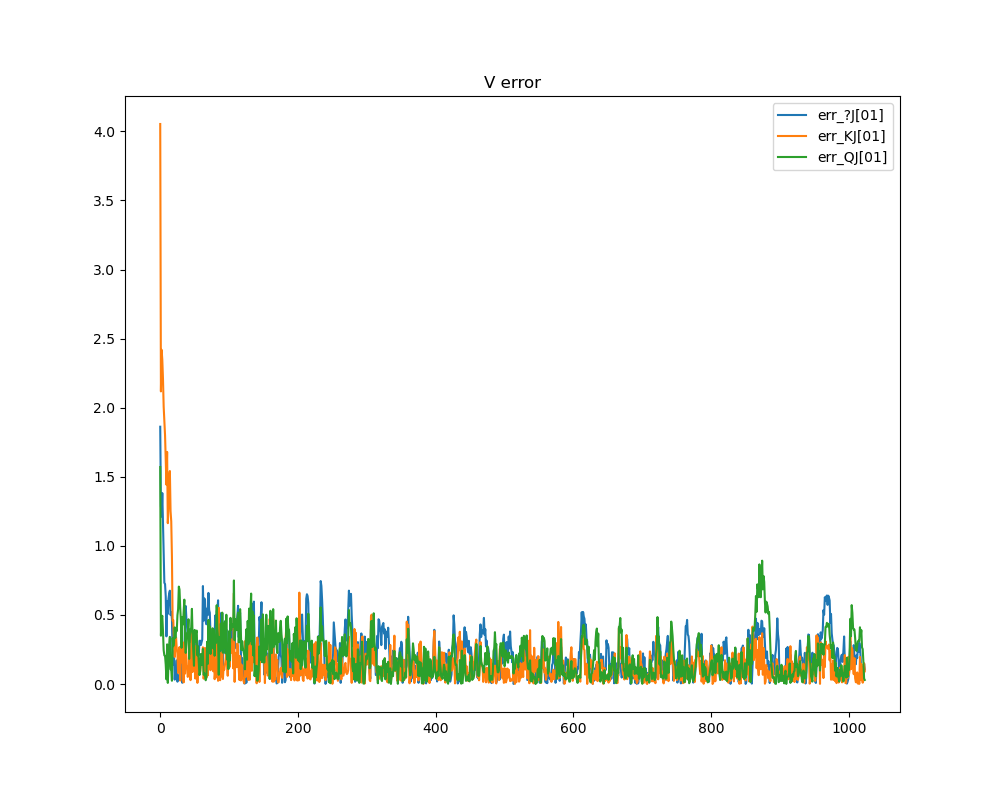

Text(0.5, 1.0, 'V error')

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(df_model.index, df_model['err_?J[01]'], label='err_?J[01]')
plt.plot(df_model.index, df_model['err_KJ[01]'], label='err_KJ[01]')
plt.plot(df_model.index, df_model['err_QJ[01]'], label='err_QJ[01]')
plt.legend()
plt.title('V error')

<IPython.core.display.Javascript object>


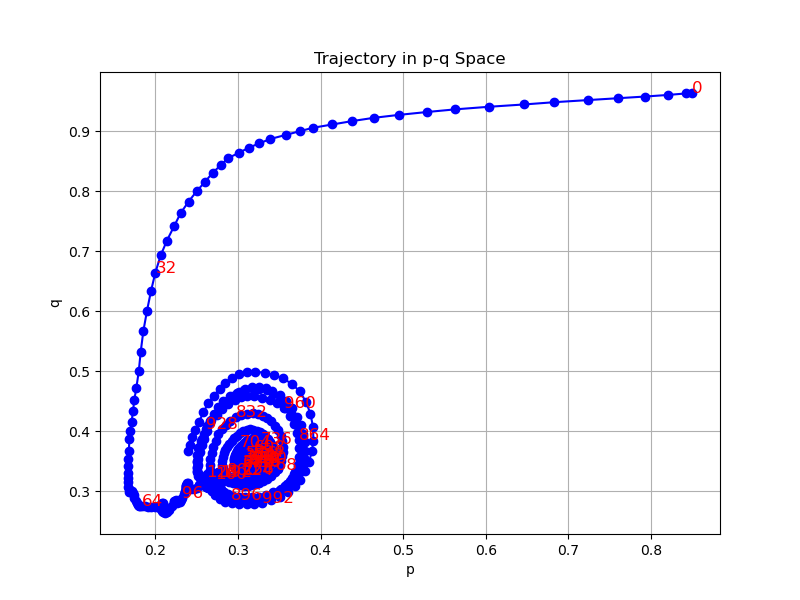

In [12]:
data = df_model

plt.figure(figsize=(8, 6)) 
plt.plot(data['p'], data['q'], marker='o', linestyle='-', color='b')
plt.title('Trajectory in p-q Space') 
plt.xlabel('p')  
plt.ylabel('q') 
plt.grid(True) 

# Annotate every 10th point with its order number
for i, (p, q) in enumerate(zip(data['p'], data['q'])):
    if i % 32 == 0: 
        plt.text(p, q, str(i), color="red", fontsize=12)
        
plt.scatter([1/3], [1/3], color='green', s=100, marker='x', label='Target (1/3, 1/3)')

plt.show()


In [13]:
with open('self_play/positions_0.001eps', 'rb') as f:
    positions = pickle.load(f)

df = pd.DataFrame(positions)

In [14]:
p_ix = df['info_set'].apply(lambda x: (x.action_history == [0]) and (x.cards == [None, Card.JACK]))
q_ix = df['info_set'].apply(lambda x: (x.action_history == [0, 1]) and (x.cards == [Card.QUEEN, None]))

In [15]:
df.loc[p_ix, 'p'] = df.loc[p_ix, 'policy_target'].apply(lambda x: x[1])
df.loc[q_ix, 'q'] = df.loc[q_ix, 'policy_target'].apply(lambda x: x[1])

In [16]:
p_hat = df[df['p'].notna()].groupby('gen_id')['p'].mean()
q_hat = df[df['q'].notna()].groupby('gen_id')['q'].mean()

<IPython.core.display.Javascript object>


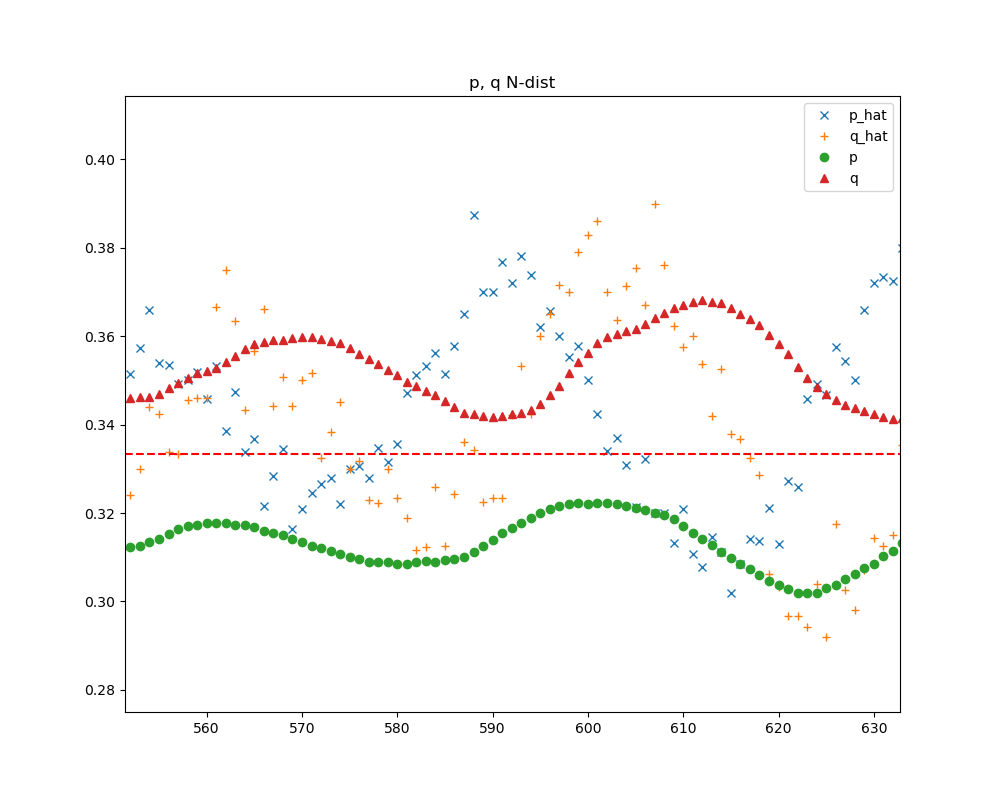

Text(0.5, 1.0, 'p, q N-dist')

In [20]:
plt.figure(figsize=(10, 8))
plt.plot(p_hat.index, p_hat,'x', label='p_hat')
plt.plot(q_hat.index, q_hat, '+', label='q_hat')
plt.plot(df_model.index, df_model['p'], 'o', label='p')
plt.plot(df_model.index, df_model['q'], '^', label='q')
plt.axhline(y=1/3, color='r', linestyle='--')
plt.legend()
plt.title('p, q N-dist')